In [1]:
import sys 
import os
sys.path.append('C:/Download/path/Goundcoupled GPR')
import Pavement_thickness_detection as ptd
import numpy as np
import pickle
from scipy.constants import c as c

H:/GPR pavement thickness/Pavement_thickness_measurement_to_Steve/Goundcoupled GPR/ALF GPR Lane 6, 09-21-23
Now reading data from Lane 6 Pass 1
Median (50th percentile): 4.48 inches


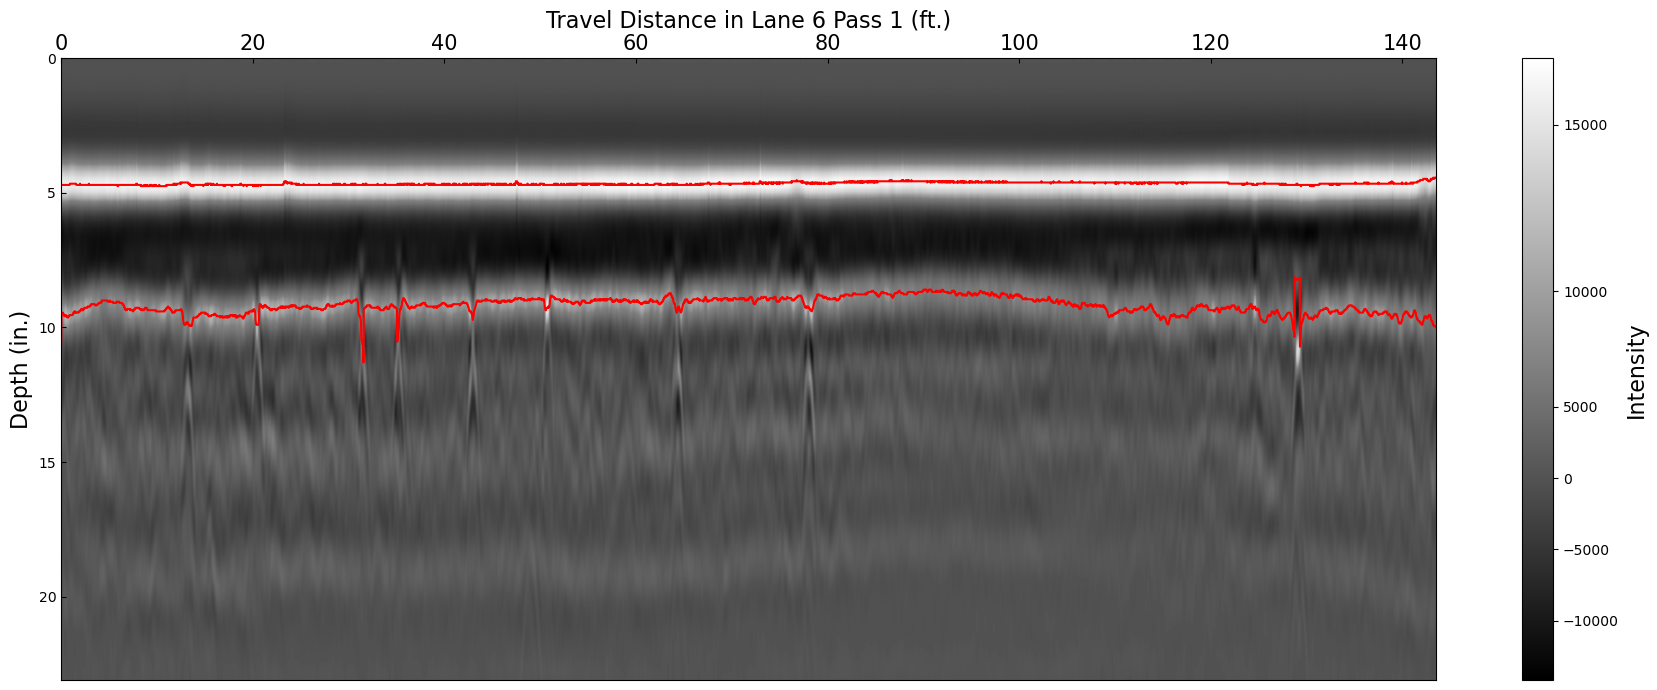

Now reading data from Lane 6 Pass 2
Median (50th percentile): 4.66 inches


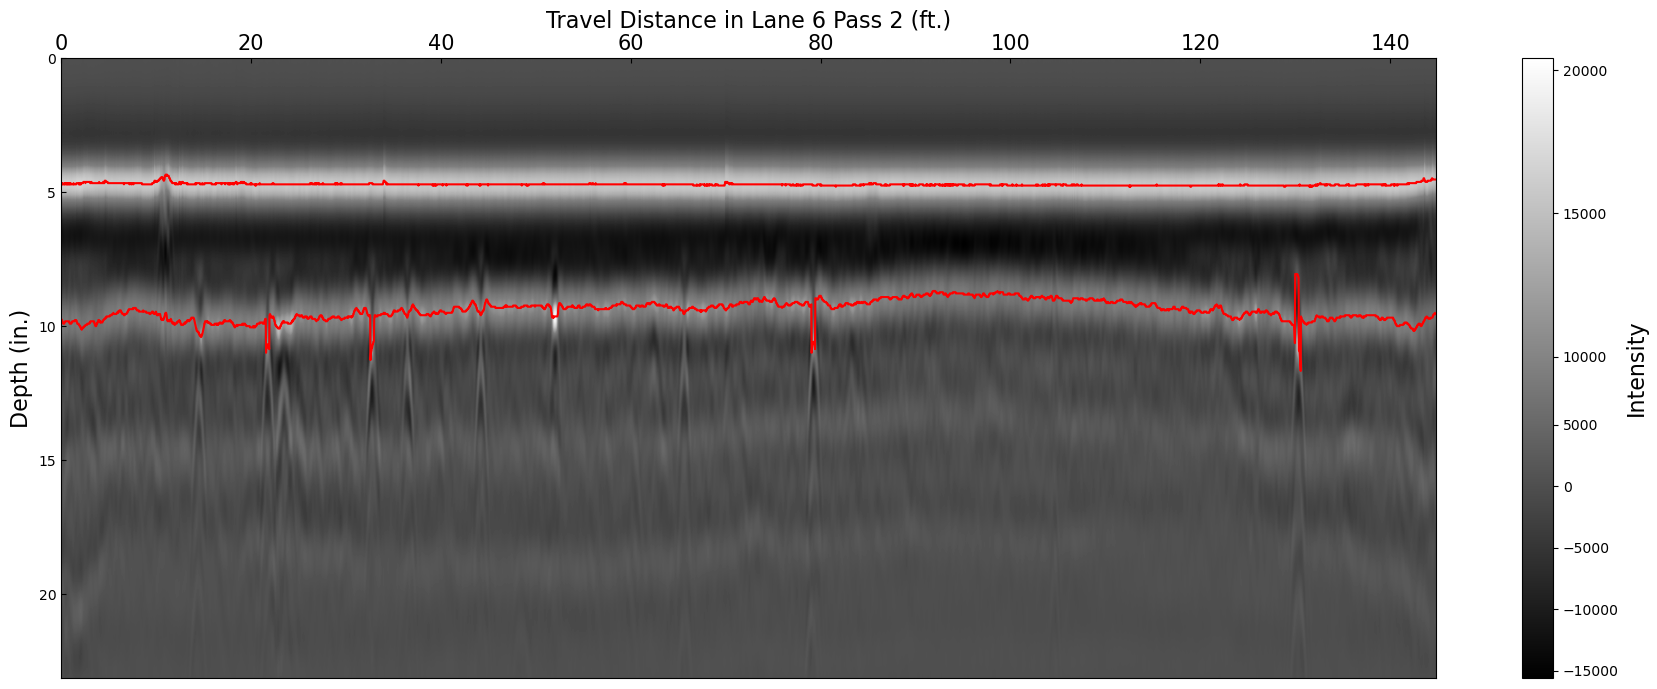

Now reading data from Lane 6 Pass 3
Median (50th percentile): 4.66 inches


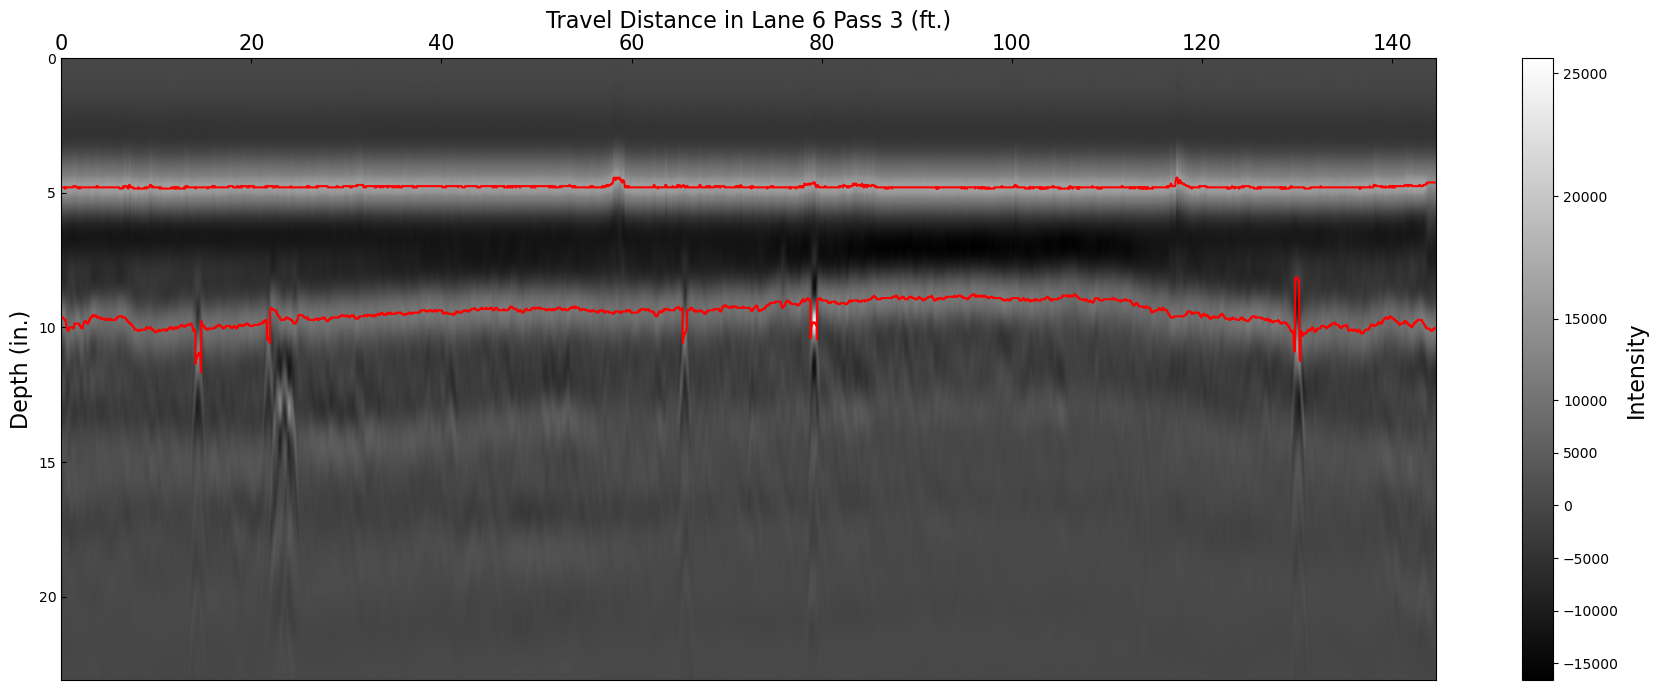

Now reading data from Lane 6 Pass 4
Median (50th percentile): 4.57 inches


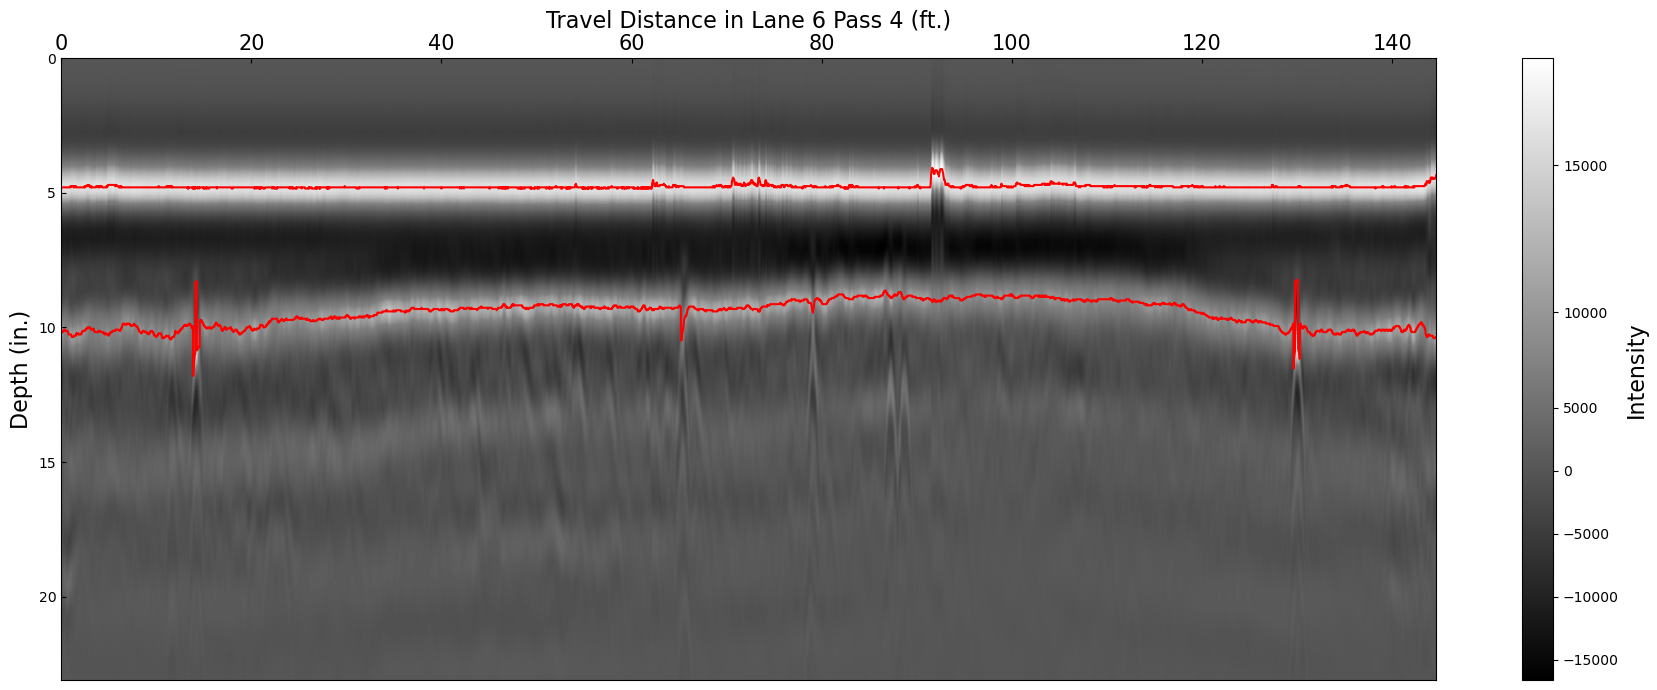

Now reading data from Lane 6 Pass 5
Median (50th percentile): 4.48 inches


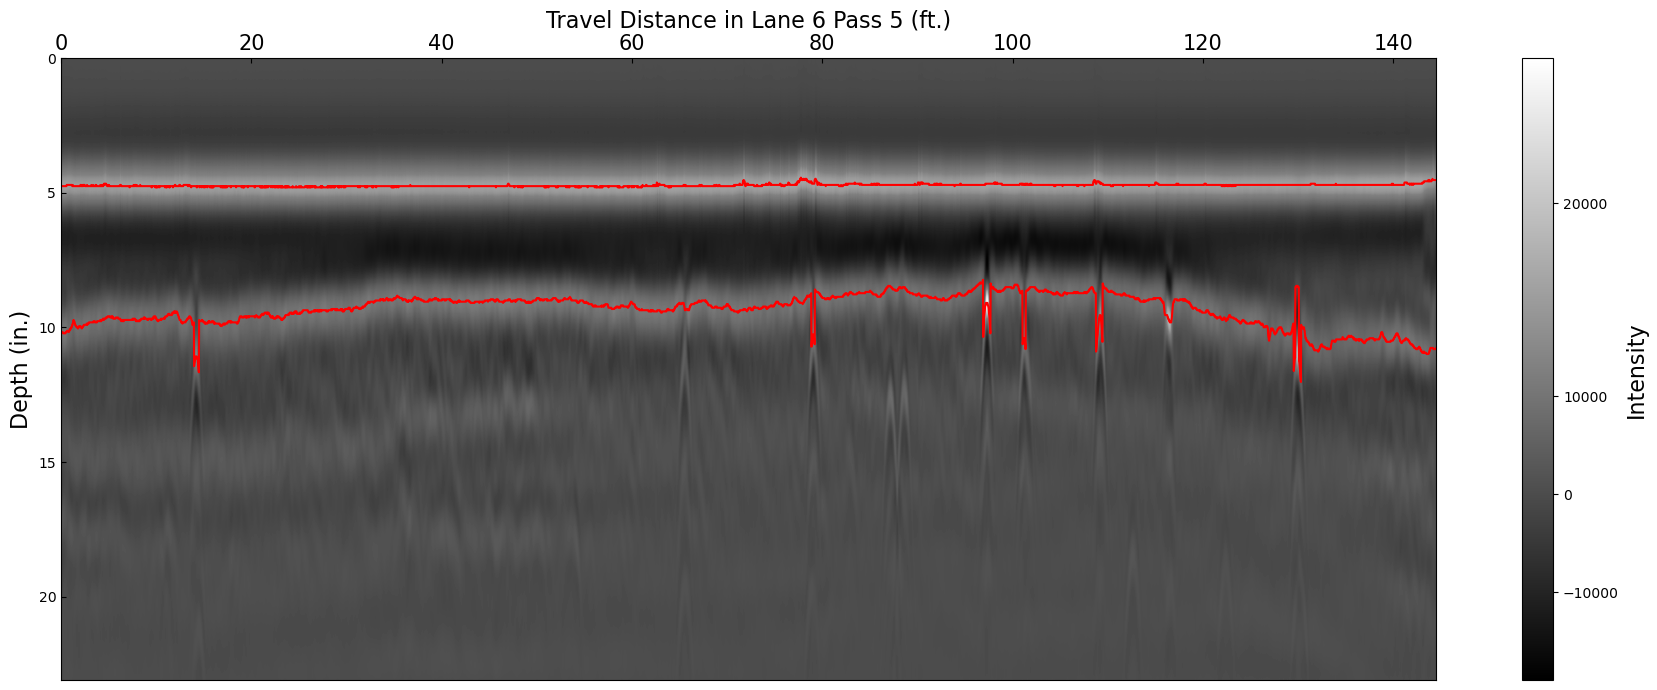

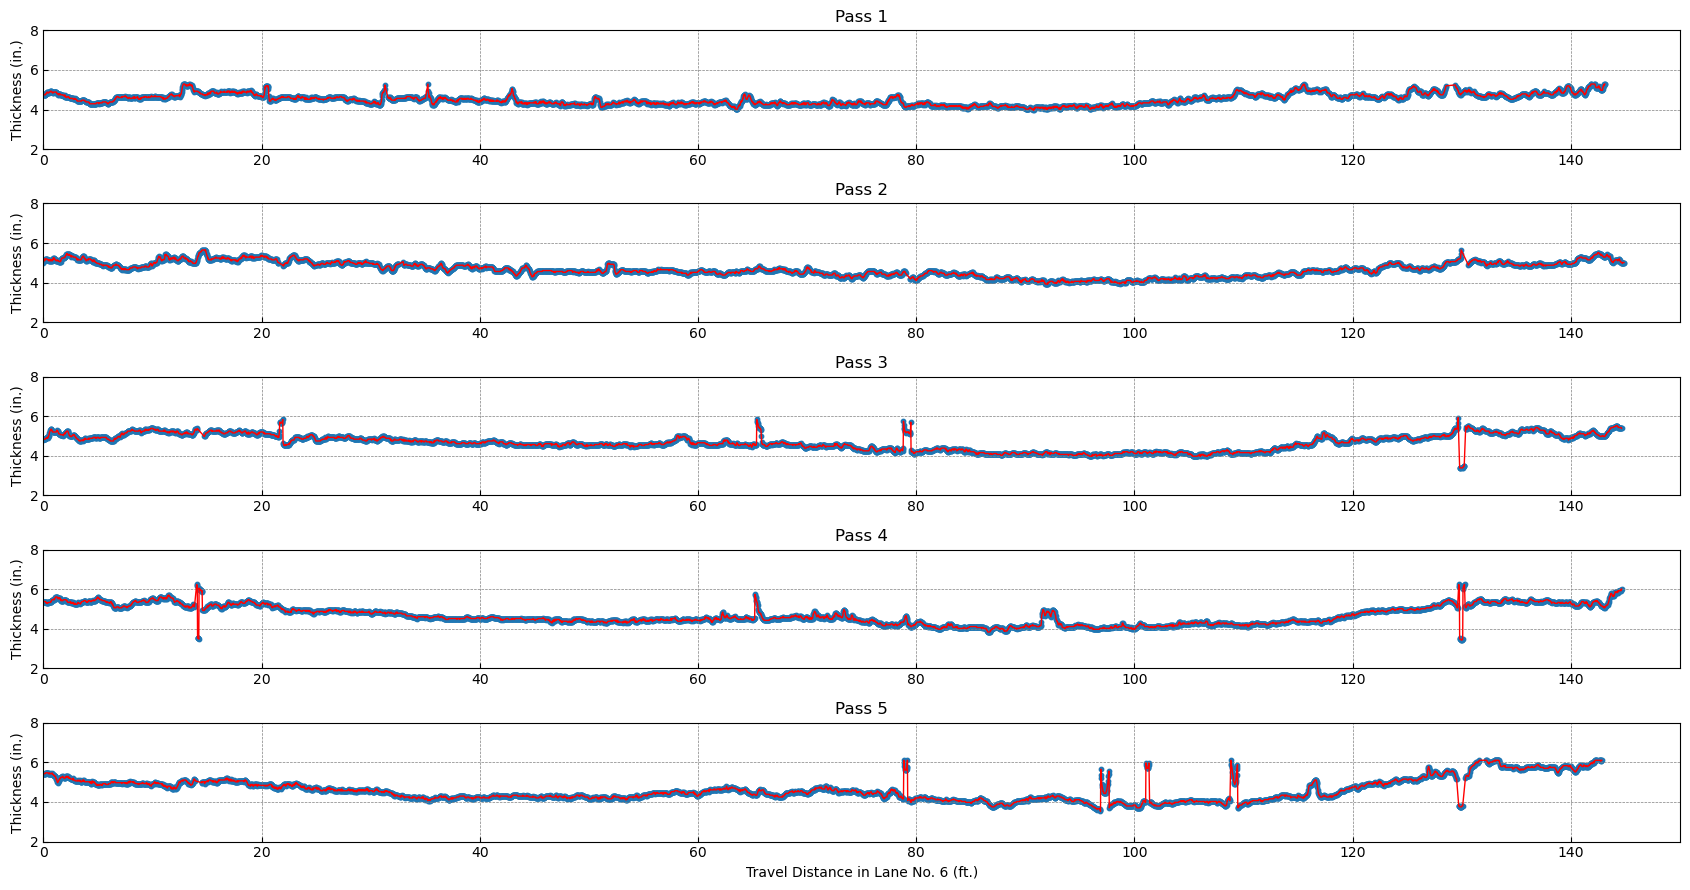

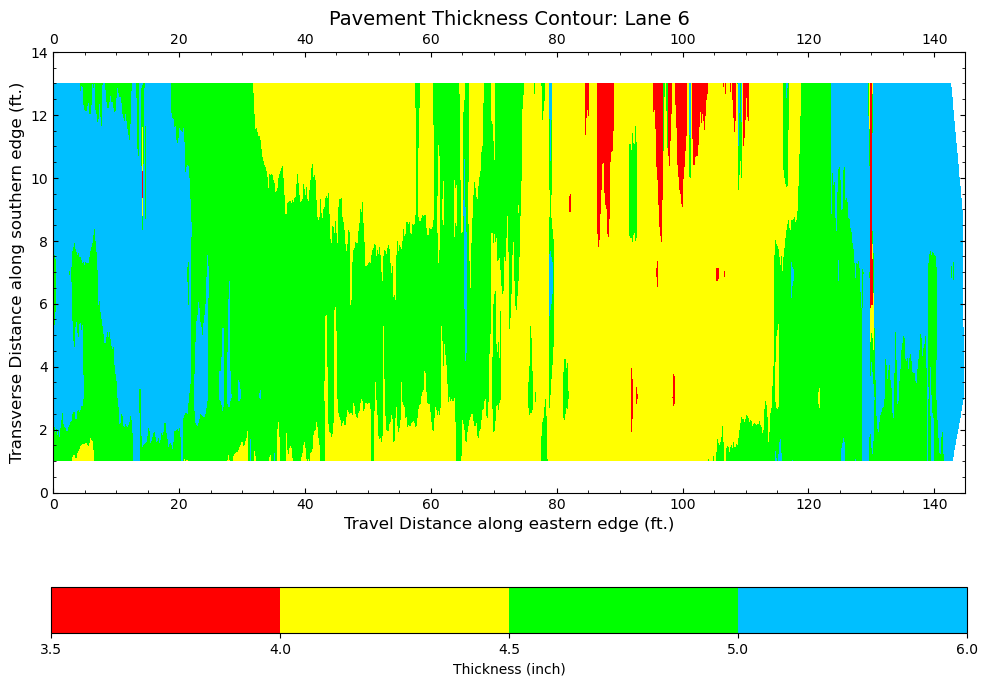

In [2]:
# Input Module
Project_folder = 'C:/Download/path/Goundcoupled GPR/'

with_outliers = True # Uses outlier removal function for measured pavement thickness. If set to False, returns originally measured data.
positive_pick = True # If set to False, GPR negative amplitude is used to measure the pavement thickness.
no_color_transition = True # If set to False, the colorbar in the legend will represent a continuous scale of colors.
dielectric_constant = 6.5  # rhf_espr in GPR configuration.

# Specify the testing offset (transverse testing interval between scan passes)
Distance_Y_1 = np.array([1, 3, 7, 9, 13])  # Lane 3 6 9 11; east end is zero
Distance_Y_2 = np.array([13, 11, 7, 5, 1])  # Lane 1 4 7; east end is zero
Distance_Y_3 = np.array([11, 9, 6, 3, 1])  # Lane 2 5 8; east end is zero

# Process data for the pavement thickness analysis
with os.scandir(Project_folder) as entries:
    for entry in entries:
        if entry.is_dir() and not entry.name.startswith('_'):
            lane_folder = entry.name
            folder_current = os.path.join(Project_folder, lane_folder)

    for file in os.listdir(folder_current):
        # Reading dzt files
        if file.endswith('.DZT'):
            Data_file_name = file
            Lane_num = []
            ScanPass_num = []
            Lane_num = ptd.next_letter_after_substring(file, "Lane")
            ScanPass_num = ptd.next_letter_after_substring(file, "Pass")
            print("Now reading data from Lane {} Pass {}".format(Lane_num, ScanPass_num))

            # dzt file processing
            if not folder_current.endswith('/') and not folder_current.endswith('\\'):
                folder_current += '/'
            df_1, df_2 = ptd.gpr_lr.readdzt(folder_current + Data_file_name)
            
            # Allocate all the GPR configuration settings as variables in Python
            result_variables = ptd.gpr_lr.config_to_variable(df_2)
            locals().update(result_variables)
            
            df_1c = ptd.clean_A_scan(df_1, positive_pick)

            # Collect peak point locations
            peaks_all = ptd.Collect_surface_thickness(df_1c)

            # Time difference between two peaks specified
            Time_difference = (peaks_all[1, :] - peaks_all[0, :]) / peaks_all.shape[0] * rhf_range / (1e+9)  # unit: s

            # Wave velocity in a media
            Travel_velocity = c / np.sqrt(dielectric_constant)  # unit: m/s

            # Pavement thickness calculated
            Thickness_ = (Travel_velocity * Time_difference) / 2 * 39.3701  # unit: inch

            # GPR scan distance
            distance_ = np.linspace(0, Thickness_.shape[0] - 1, Thickness_.shape[0]) / rhf_spm * 3.28084
            
            # Postprocessing
            print(f'Median (50th percentile): {np.percentile(Thickness_, 50):.2f} inches')

            # Plot GPR B-scan
            ptd.Plot_b_scan_advanced(df_1c, Travel_velocity, distance_, peaks_all[0, :], peaks_all[1, :], rhf_spm, rhf_range, Lane_num, ScanPass_num, 0.7)

            # remove outiliers
            Thickness_cleaned, indices_within_limits, _ = ptd.IQR_outlier_removal(Thickness_)

            # Save pavement depth coordinates
            cal_result = {}
            cal_result = {'Distance_original': distance_, 'Thickness_original': Thickness_, 'Distance_cleaned': distance_[indices_within_limits], 'Thickness_cleaned': Thickness_cleaned}
            with open(f'{folder_current}/Lane_{Lane_num}_Pass_{ScanPass_num}.pickle', 'wb') as f5:
                pickle.dump(cal_result, f5)

    # Concatenate pavement lane data
    Distance_Y = []
    if Lane_num == "1" or Lane_num == "4" or Lane_num == "7" or Lane_num == "10":
        Distance_Y = Distance_Y_2  # Lane 1 4 7 10
    elif Lane_num == "3" or Lane_num == "6" or Lane_num == "9" or Lane_num == "11":
        Distance_Y = Distance_Y_1  # Lane 3 6 9 11
    elif Lane_num == "2" or Lane_num == "5" or Lane_num == "8":
        Distance_Y = Distance_Y_3  # Lane 2 5 8

    # Read pavement depth coordinates
    Distance_X, Thickness_Z = ptd.load_pavement_depth_coordinates(folder_current, with_outliers=True)

    # Plot thickness vs. distance for all passes in one figure
    ptd.thickness_plot_2D(Distance_X, Thickness_Z, Lane_num, 5)

    # Data Interpolation
    X_fine, Y_fine, result_interp_fine = ptd.interpolate_thickness(Distance_X, Distance_Y, Thickness_Z)

    # Contour plot
    colors = ['red', 'yellow', 'lime', 'deepskyblue'] # color designation
    bounds = [3.5, 4, 4.5, 5, 6]  # Boundaries for each color
    ptd.contour_plot_No_Transition(Y_fine, X_fine, result_interp_fine, colors, bounds, Lane_num) if no_color_transition == True else ptd.contour_plot_default(Y_fine, X_fine, result_interp_fine, Lane_num)